# PREDICT DIFFERENCE IN REALISED VOLATILITY

## 0. Setup and Configuration

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import sys
import os

# Ensure we can import from the src folder
sys.path.append(os.path.abspath('..'))

from src.data import download_data, compute_features, create_sequences
from src.lstm import LSTMDataset, LSTMRegressor, train_lstm

# --- Global Configuration ---
TICKER = "TSLA"
START_DATE = "2015-01-01"
SEQ_LEN = 30
BATCH_SIZE = 32
FEATURE_COLS = [
    "LogReturn", "RealisedVolatility", "RSI_14",
    "BB_Width", "MACD", "YZVolatility", "Log_CO", "Log_HL",
]

# --- Helper Function for Reconstruction & Evaluation ---
def evaluate_diff_model(preds_diff, y_prev_raw, y_actual_raw, model_name, dates):
    """
    Reconstructs actual values from predicted differences and calculates metrics.
    
    Args:
        preds_diff: The model's predicted changes (y_t - y_{t-1})
        y_prev_raw: The actual values at t-1 (for reconstruction)
        y_actual_raw: The actual values at t (ground truth)
        model_name: Name for plotting
        dates: Dates for plotting
    """
    # Reconstruction: Pred_t = Actual_{t-1} + Pred_Diff_t
    preds_reconstructed = y_prev_raw + preds_diff
    
    # Calculate Metrics
    mae = mean_absolute_error(y_actual_raw, preds_reconstructed)
    rmse = np.sqrt(mean_squared_error(y_actual_raw, preds_reconstructed))
    
    print(f"--- {model_name} Performance ---")
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    
    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(dates, y_actual_raw, label='Actual RV', color='blue', alpha=0.6)
    plt.plot(dates, preds_reconstructed, label=f'{model_name} Prediction', color='red', linestyle='--', alpha=0.8)
    plt.title(f"{model_name}: Reconstructed Predictions vs Actuals ({TICKER})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mae, rmse, preds_reconstructed

In [ ]:
print("1. Loading and computing features...")
df = download_data(TICKER, start_date=START_DATE)
df = compute_features(df)

# Create Difference Target: Diff_t = RV_t - RV_{t-1}
df["RV_Diff"] = df["RealisedVolatility"].diff()
df = df.dropna()

# --- Scaling (Fit on Train Only) ---
train_size_pct = 0.7
train_split_idx = int(len(df) * train_size_pct)

scaler = StandardScaler()
scaler.fit(df[FEATURE_COLS].iloc[:train_split_idx])
df.loc[:, FEATURE_COLS] = scaler.transform(df[FEATURE_COLS])

# --- Sequence Creation ---
# 1. Scaled Features & Difference Target (For Training)
X, y_diff, dates = create_sequences(df, FEATURE_COLS, target_col="RV_Diff", seq_len=SEQ_LEN)

# 2. Unscaled Raw Target (For Reconstruction/Evaluation later)
# We re-run create_sequences on the raw dataframe to align indices perfectly
_, y_raw, _ = create_sequences(df, FEATURE_COLS, target_col="RealisedVolatility", seq_len=SEQ_LEN)

# --- Train/Val/Test Split ---
test_size_pct = 0.15
n_samples = len(X)
train_end = int(n_samples * train_size_pct)
test_start = int(n_samples * (1 - test_size_pct))

# Training Sets
X_train = X[:train_end]
y_train_diff = y_diff[:train_end]

# Validation Sets
X_val = X[train_end:test_start]
y_val_diff = y_diff[train_end:test_start]

# Test Sets
X_test = X[test_start:]
y_test_diff = y_diff[test_start:]
dates_test = dates[test_start:]

# --- Reconstruction Targets for Test Set ---
# y_raw[i] is RV at time t. 
# For the test set starting at `test_start`, the "previous" value is at `test_start - 1`
y_test_prev_raw = y_raw[test_start-1 : -1]  # The anchor for reconstruction
y_test_actual_raw = y_raw[test_start:]      # The ground truth

print(f"Data processed. Train samples: {len(X_train)}, Test samples: {len(X_test)}")

1. Loading and computing features...


[*********************100%***********************]  1 of 1 completed

Data processed. Train samples: 1887, Test samples: 405


## 1. Models

### 1.1 Random Forest

Training Random Forest...
--- Random Forest Performance ---
MAE:  0.089879
RMSE: 0.192110


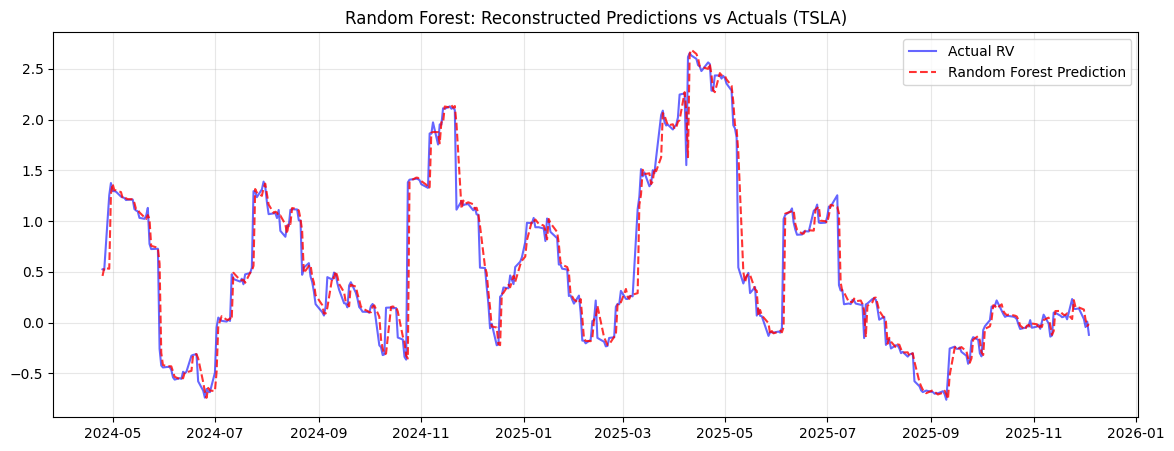

In [ ]:
# 1. Flatten inputs: (N, Seq_Len, Features) -> (N, Seq_Len * Features)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# 2. Initialize and Train
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_rf, y_train_diff)

# 3. Predict Differences
rf_preds_diff = rf_model.predict(X_test_rf)

# 4. Evaluate using Helper
rf_mae, rf_rmse, rf_preds_final = evaluate_diff_model(
    rf_preds_diff, y_test_prev_raw, y_test_actual_raw, "Random Forest", dates_test
)

### 1.2 LSTM

Training LSTM...
Epoch 10/50 | Train RMSE: 0.039223 | Val RMSE: 0.035984
Epoch 20/50 | Train RMSE: 0.038605 | Val RMSE: 0.035916
Early stopping at epoch 24. Best Val RMSE: 0.034793, at epoch 14.

Training finished. Best model saved to ../models/TSLA_diff_lstm.pth 
Best Val RMSE: 0.034793 at epoch 14

--- LSTM Performance ---
MAE:  0.098003
RMSE: 0.206895


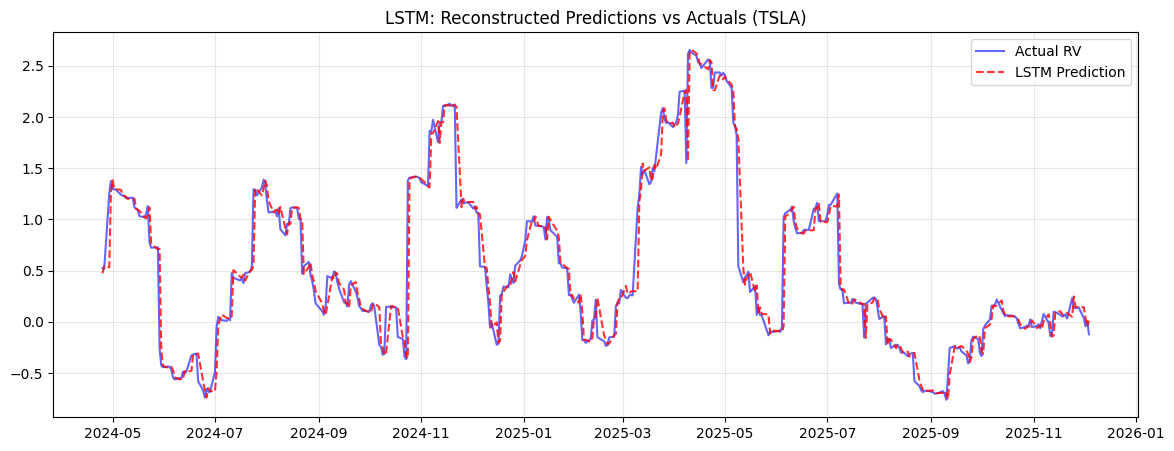

In [ ]:
# 1. Prepare DataLoaders
train_loader = DataLoader(LSTMDataset(X_train, y_train_diff), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LSTMDataset(X_val, y_val_diff), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(LSTMDataset(X_test, y_test_diff), batch_size=BATCH_SIZE, shuffle=False)

# 2. Initialize Model
lstm_model = LSTMRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)

# 3. Train
print("Training LSTM...")
train_hist = train_lstm(
    lstm_model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.001,
    patience=10,
    model_name=f"{TICKER}_diff_lstm.pth"
)

# 4. Predict Differences
lstm_model.eval()
lstm_preds_diff = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        out = lstm_model(X_batch)
        lstm_preds_diff.extend(out.squeeze().numpy())
lstm_preds_diff = np.array(lstm_preds_diff)

# 5. Evaluate using Helper
lstm_mae, lstm_rmse, lstm_preds_final = evaluate_diff_model(
    lstm_preds_diff, y_test_prev_raw, y_test_actual_raw, "LSTM", dates_test
)

Final Comparison (Reconstructed Values):
           Model       MAE      RMSE
0  Random Forest  0.089879  0.192110
1           LSTM  0.098003  0.206895


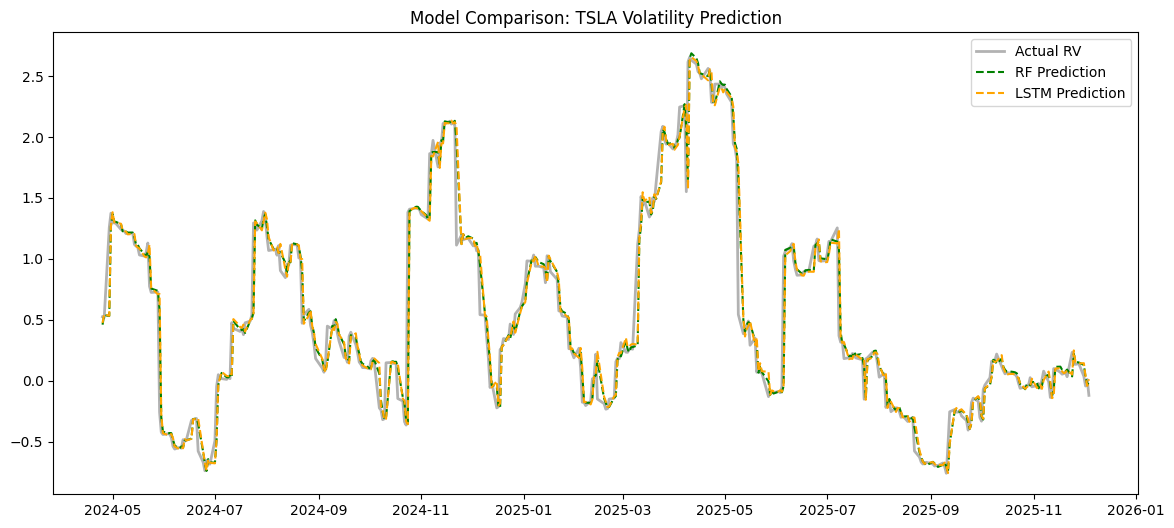

In [5]:
# ---------------------------------------------------------
# CELL 5: Results Summary
# ---------------------------------------------------------
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'MAE': [rf_mae, lstm_mae],
    'RMSE': [rf_rmse, lstm_rmse]
})

print("Final Comparison (Reconstructed Values):")
print(results_df)

# Optional: Plot both together
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_actual_raw, label='Actual RV', color='black', linewidth=2, alpha=0.3)
plt.plot(dates_test, rf_preds_final, label='RF Prediction', color='green', linestyle='--')
plt.plot(dates_test, lstm_preds_final, label='LSTM Prediction', color='orange', linestyle='--')
plt.title(f"Model Comparison: {TICKER} Volatility Prediction")
plt.legend()
plt.show()

## 2. XAI

### 2.1 SHAP

#### a) Random Forest Regressor

Random Forest: Top 10 Features driving Volatility Change


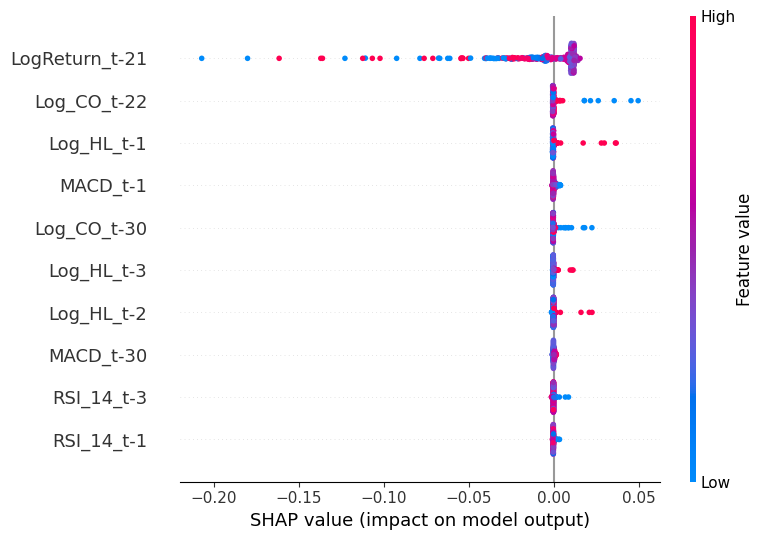

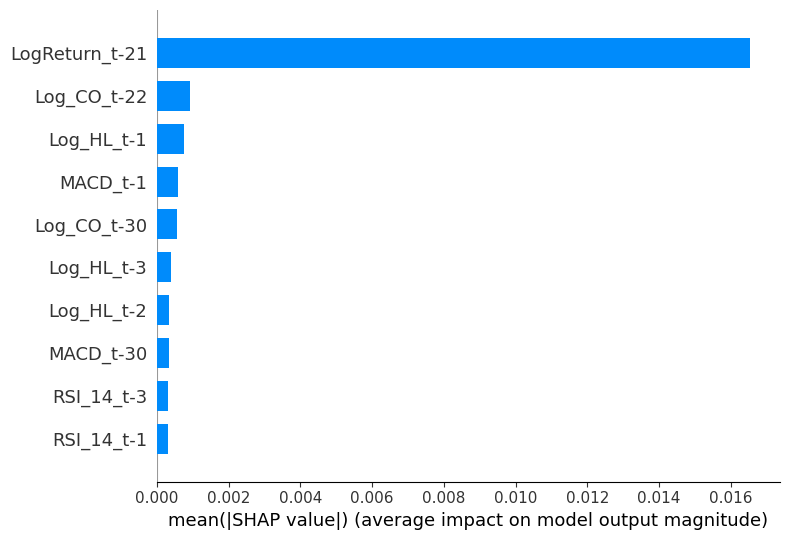

In [ ]:
import shap

# 1. Create readable feature names for the flattened input
# The RF sees 30 days * 8 features = 240 columns. We name them t-30 to t-1.
rf_feature_names = []
for i in range(SEQ_LEN):
    for col in FEATURE_COLS:
        # SEQ_LEN - i gives us t-30, t-29, ... t-1
        rf_feature_names.append(f"{col}_t-{SEQ_LEN - i}")

# 2. Create a DataFrame for SHAP (needs column names)
# X_test_rf is the flattened numpy array we created in Cell 3
X_test_rf_df = pd.DataFrame(X_test_rf, columns=rf_feature_names)

# 3. Select a background sample (SHAP is computationally expensive)
# We take 500 random samples from the test set
X_shap = X_test_rf_df.sample(n=min(500, len(X_test_rf_df)), random_state=42)

# 4. Initialize Explainer
# rf_model is the trained model from Cell 3
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_shap)

# 5. Plotting
print("Random Forest: Top 10 Features driving Volatility Change")
# Select top 10 features by mean absolute SHAP value
most_important_indices = np.argsort(-np.abs(shap_values_rf).mean(0))[:10]
X_shap_selected = X_shap.iloc[:, most_important_indices]
shap_values_selected = shap_values_rf[:, most_important_indices]

shap.summary_plot(shap_values_selected, X_shap_selected, show=True)
shap.summary_plot(shap_values_selected, X_shap_selected, plot_type="bar", show=True)

#### b) LSTM Regressor

Attributions shape: torch.Size([50, 30, 8])


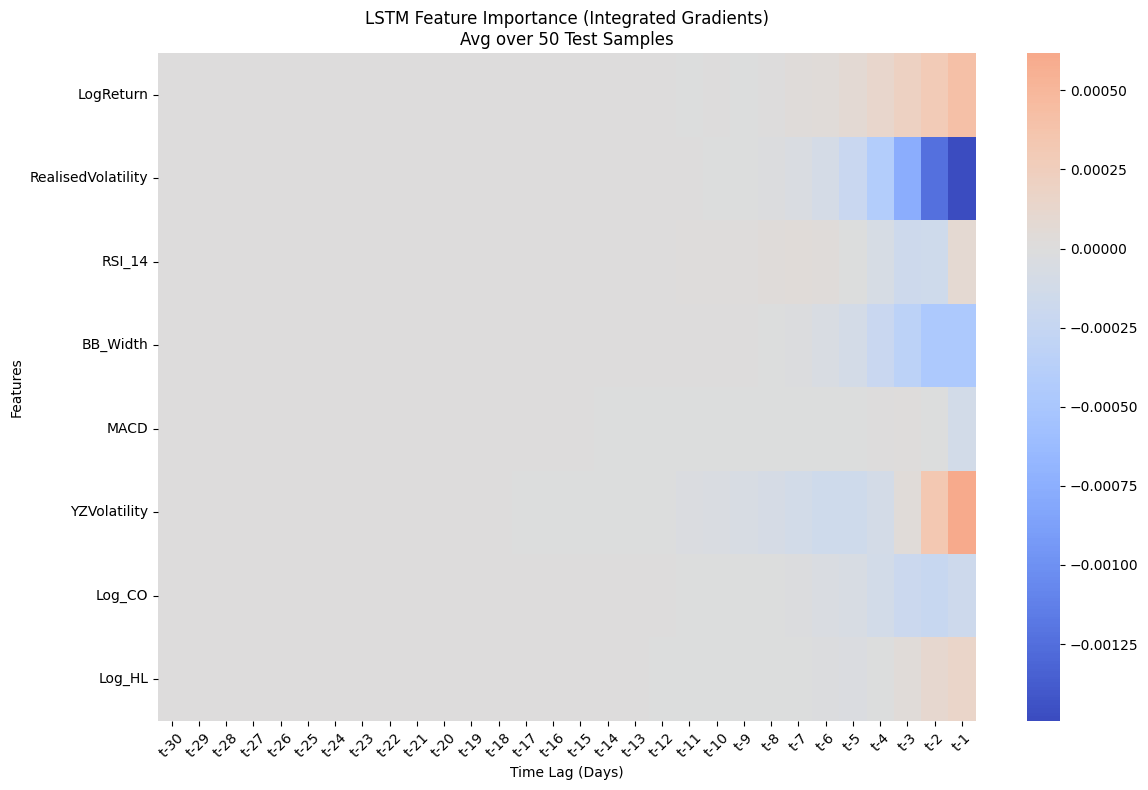

In [7]:
from captum.attr import IntegratedGradients
import seaborn as sns

# 1. Prepare a sample batch
# We take the first 50 examples from the test set
# X_test is the 3D numpy array (N, 30, 8) from Cell 2
sample_idx = 50
sample_x_np = X_test[:sample_idx]
# Convert to torch Tensor for the model
sample_x_tensor = torch.tensor(sample_x_np, dtype=torch.float32)
# Ensure gradients are tracked for attribution
sample_x_tensor.requires_grad = True

# 2. Initialize Integrated Gradients
# lstm_model is the trained model from Cell 4
ig = IntegratedGradients(lstm_model)

# 3. Compute Attribution
# This calculates the integral of gradients
attr, delta = ig.attribute(sample_x_tensor, return_convergence_delta=True)

print(f"Attributions shape: {attr.shape}")

# 4. Visualization (Heatmap)
# We average the attributions over the 50 samples to see the "global" importance pattern
attr_mean = attr.detach().numpy().mean(axis=0) # Shape: (30, 8)

plt.figure(figsize=(12, 8))
sns.heatmap(attr_mean.T, # Transpose so Time is X-axis, Features are Y-axis
            xticklabels=[f"t-{SEQ_LEN-i}" for i in range(SEQ_LEN)],
            yticklabels=FEATURE_COLS,
            cmap="coolwarm",
            center=0)

plt.title("LSTM Feature Importance (Integrated Gradients)\nAvg over 50 Test Samples")
plt.xlabel("Time Lag (Days)")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()